<a href="https://colab.research.google.com/github/gauthiermartin/pytorch-deep-learning-course/blob/main/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning

## What is transfer learning

Transfer learning involves taking the parameters of what one model has learned on another dataset and apply it to our own dataset

* Pre-trained model == Foundation Model

## Why using transfer learning

* Leverage existing neural network architecture proven to work
* Leverage existing learned pattern and adapt it to our use case


## Where to find pre-trained models

* PyTorch Website - https://pytorch.org/vision/stable/index.html
* Github - https://github.com/huggingface/pytorch-image-models
* HuggingFace - https://huggingface.co/
* Papers with code - https://paperswithcode.com/sota

In [2]:
import torch
import torchvision

print(f"PyTorch Version: {torch.__version__}") # Want 1.12+
print(f"TorchVision Version : {torchvision.__version__}") # Want 0.13+

PyTorch Version: 2.0.1+cu118
TorchVision Version : 0.15.2+cu118


Now we've got the versions of torch and torchvision we wanted we will now import the code that we did in the going_modular section

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4028, done.
remote: Counting objects: 100% (1216/1216), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 4028 (delta 1065), reused 1098 (delta 1000), pack-reused 2812
Receiving objects: 100% (4028/4028), 651.38 MiB | 40.71 MiB/s, done.
Resolving deltas: 100% (2358/2358), done.
Updating files: 100% (248/248), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
!nvidia-smi

Fri Oct 13 19:44:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get data

We need our pizza, steak and sushi data to build a transfer learning model on.

In [7]:
import os
import zipfile
import requests

from pathlib import Path

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder does not exist download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists, skippping download")
else:
  print(f"Did not find {image_path}, donwloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  #Download pizza, steak and sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(response.content)

  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_file:
    print("Unzipping pizza, steak and sushi data...")
    zip_file.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")


Did not find data/pizza_steak_sushi, donwloading it...
Unzipping pizza, steak and sushi data...


In [8]:
# Setup directory path

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

 ## 2. Create Datasets and DataLoaders

 Now we've got some data, want to turn it into PyTorch DataLoaders.

 To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in 05

 There's one thing we have to think about when loading : how to **transform** it ?

 And with `torchvision` 0.13+ there is two ways to do this :
 1. Manually created transforms - You define the transforms
 2. Automatically created transforms - The transforms for your data are defined by the model you'd like to use

 Important point: when using a pre-trained model it's important the data (including custom data) is transformed in the same way that the data the model was trained on.

In [9]:
from going_modular.going_modular import data_setup

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize.
>
>


In [10]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


manual_transforms = transforms.Compose([
    transforms.Resize((224,224)), # Resize image to 224, 224 Height X Width
    transforms.ToTensor(), # Get image into range [0, 1]
    normalize # make sure images have the same distribution as ImageNet (Our pre-trained model has been trained on ImageNet Dataset)
])

In [11]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cf7b3133ac0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [12]:
# Get a set of pretrained model weights

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = Best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [13]:
# Get the transforms used to create our pretraine weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
# Create Dataloaders using automatic transforms

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cf6eb026980>,
 ['pizza', 'steak', 'sushi'])

from torch._C import PyTorchFileReader
## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch
2. Librairies like `timm` (torch image models)
3. Hugging Face Hub
4. Paper with code

### 3.1 Which pretrained model should you use ?

*Experiment, Experiment, Experiment!*

The whole idea of transfer learning is taking a well-performing model from a problem space and customize it to our own problem.

Three things to consider:
1. Speed - how fast does it run ?
2. Size - how big is the model ?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images, For food vision mini ? )

Where does the model live ?

Is it on device (self-driving car)

Or does it live on a server


Looking at https://pytorch.org/vision/0.16/models.html#listing-and-retrieving-available-models

Which model should we choose?


For our case, it look like the EffNetB0 is one of our best options in terms performance vs size.

However, in light of the Bitter Lesson, if we had infinite compute we'd likely pick the biggest model + most parameters + most general we can get.

Look at - http://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 3.2 Setting up a pretrained model

We want to create an instance of a pretrained EffNetB0 - https://pytorch.org/vision/0.16/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights

In [15]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
model = torchvision.models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 158MB/s] 


In [16]:
# New method of creating a pretrained model

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [18]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [19]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [20]:
from torchinfo import summary
summary(
    model=model,
    input_size=(1, 3, 224, 244), # example of [batch_size, color_channels, height, width]
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 244]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 244]     [1, 1280, 7, 8]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 244]     [1, 32, 112, 122]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 244]     [1, 32, 112, 122]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 122]    [1, 32, 112, 122]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 122]    [1, 32, 112, 122]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 122]    [1, 16, 112,

## 3.4 Freezing the base model and changing the output layer to suit our needs

With feature extractor model, typically you will "freeze" the base layers of a pretrained model
and update the output layer to suit your own probleme

In [21]:
# Freeze all of the base layers in EffNetB0

for param in model.features.parameters():
  param.requires_grad = False # PyTorch won't track gradiant during the training process for these parameters

In [22]:
from torchinfo import summary
summary(
    model=model,
    input_size=(1, 3, 224, 244), # example of [batch_size, color_channels, height, width]
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 244]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 244]     [1, 1280, 7, 8]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 244]     [1, 32, 112, 122]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 244]     [1, 32, 112, 122]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 122]    [1, 32, 112, 122]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 122]    [1, 32, 112, 122]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 122]    [1, 1

In [23]:
# Display current classifier head
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [24]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

In [25]:
from torchinfo import summary
summary(
    model=model,
    input_size=(1, 3, 224, 244), # example of [batch_size, color_channels, height, width]
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 244]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 244]     [1, 1280, 7, 8]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 244]     [1, 32, 112, 122]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 244]     [1, 32, 112, 122]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 122]    [1, 32, 112, 122]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 122]    [1, 32, 112, 122]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 122]    [1, 1

## 4. Train model

In [26]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
from going_modular.going_modular import engine


# Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results

results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)

# End timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time:{end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time:16.746 seconds


In [28]:
results

{'train_loss': [1.0924270302057266,
  0.8716965466737747,
  0.7647950053215027,
  0.7108825147151947,
  0.6254764348268509],
 'train_acc': [0.3984375, 0.77734375, 0.79296875, 0.75390625, 0.78515625],
 'test_loss': [0.9132680694262186,
  0.791197657585144,
  0.7463406721750895,
  0.6373109420140585,
  0.6261006991068522],
 'test_acc': [0.5397727272727273,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8560606060606061]}

## 5. Evaluate our model by plotting loss curve

In [29]:
try:
  from helper_functions import plot_loss_curves
except ImportError as imp_err:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    response = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(response.content)

[INFO] Couldn't find helper_functions.py, downloading...


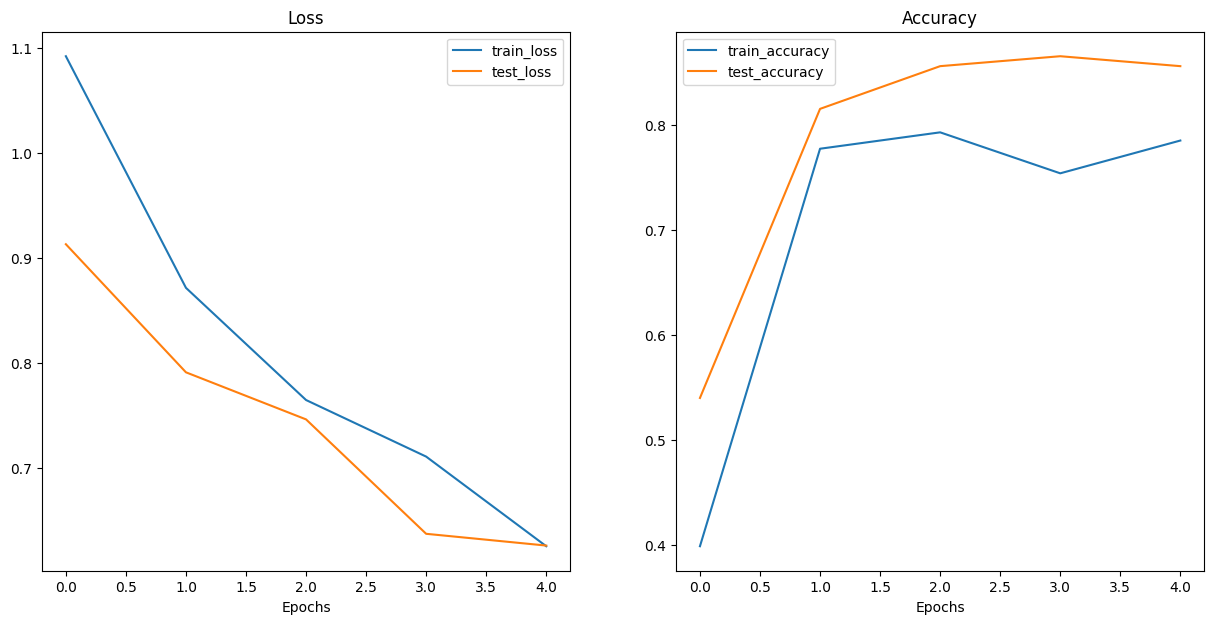

In [30]:
# Plot the loss curves result of our model

from helper_functions import plot_loss_curves

plot_loss_curves(results)

# What do our loss curve looks like in term of ideal loss curve
See more here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

## 6. Make predicitions on images from the test set

Let's adhere to the data explorer's motto of *Visualize, visualize, visualize*

And make some qualitative predictions on our test set

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is :
* Same Shape - images need to be the same shape as model was trained on
* Same datatype - custom data should be in the same datatype
* Same device - custom data/test data should be on the same device as the model
* Same transfroms - If you've transform your custom data, idealy you will transform test data and custom data the same

To do all of this automagically, let's create a function called `pred_and_plot_image`

1. Take in trained model, list of class names, a filepath to target image, image size, transforms, and target device
2. Open image with PIL
3. Crate a transform if one does not exist
4. Make sure the model is on the target device
5. Make sure the data is on the targer device
6. Turn model in eval mode
7. Transform target image and make sure that is dimentionality is suited for model (batch size)
8. Make a prediciton
9. Convert the model output logits to pred prob `torch.softmax`
10. Convert model pred prob into labels
11. Plot the image with matplot lib and set title to pred label and add pred prob

In [44]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str],
    image_size: Tuple[int, int]=(224, 224),
    transform: torchvision.transforms=None,
    device: torch.device=device
):

  img = Image.open(image_path)


  if transform is not None :
    image_transform = transform
  else:
    image_transform = transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]
    )

    ## Predict on image
    model.to(device)

    model.eval()
    with torch.inference_mode():

      transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channel, height, width]


    target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max(): .3f}")


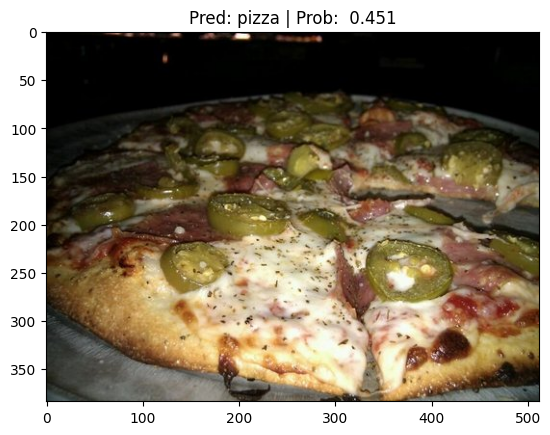

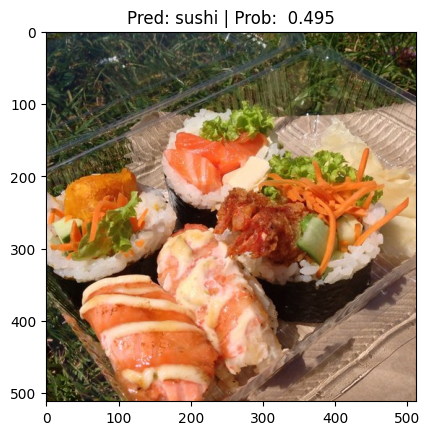

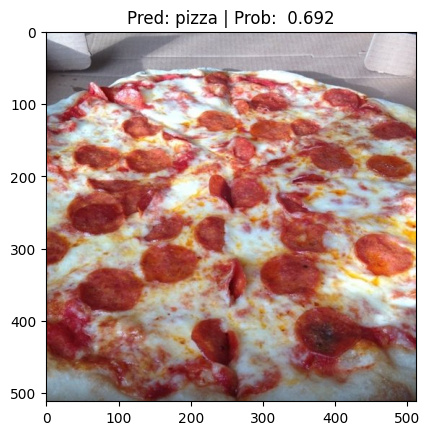

In [49]:
# Get a random subset of image path from test dataset

import random

num_image_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list, k=num_image_to_plot)


# Make predicition and on plot the images

for image_path in test_image_path_sample:
  pred_and_plot_image(
      model=model,
      image_path=image_path,
      class_names=class_names,
      image_size=(224,224)
  )
